In [1]:
import os
import sys

import numpy as np
import pandas as pd

import astropy
from astropy import stats
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special

import figurefirst as fifi

In [2]:
# taken from scipy -- tweaked to compute the angular std, which is bounded by [0,pi/2] instead of the circular std
def _circfuncs_common(samples, high, low, nan_policy='propagate'):
    # Ensure samples are array-like and size is not zero
    samples = np.asarray(samples)
    if samples.size == 0:
        return np.nan, np.asarray(np.nan), np.asarray(np.nan), None

    # Recast samples as radians that range between 0 and 2 pi and calculate
    # the sine and cosine
    sin_samp = sin((samples - low)*2.*pi / (high - low))
    cos_samp = cos((samples - low)*2.*pi / (high - low))
    #sin_samp=sin(samples)
    #cos_samp=cos(samples)
    mask = None
    return samples, sin_samp, cos_samp, mask


def mycircstd(samples, high=360, low=0, axis=None, nan_policy='propagate'):

    samples, sin_samp, cos_samp, mask = _circfuncs_common(samples, high, low,
                                                          nan_policy=nan_policy)
    if mask is None:
        sin_mean = sin_samp.mean(axis=axis)  # [1] (2.2.3)
        cos_mean = cos_samp.mean(axis=axis)  # [1] (2.2.3)
    else:
        nsum = np.asarray(np.sum(~mask, axis=axis).astype(float))
        nsum[nsum == 0] = np.nan
        sin_mean = sin_samp.sum(axis=axis) / nsum
        cos_mean = cos_samp.sum(axis=axis) / nsum
    # hypot can go slightly above 1 due to rounding errors
    with np.errstate(invalid='ignore'):
        R = np.minimum(1, hypot(sin_mean, cos_mean))  # [1] (2.2.4)

    res = np.sqrt(2 * (1 -R))
    
    return res
               

In [3]:
'''
perform lag analysis on both speed and direction

This function takes a single starting value from a column of directional and s2 data in a pandas df or np array
 and returns a list of values at each desired lag.

Note, directional data must be between 0-360 degrees.
Need to convert data if in radians and/or if it goes from -180 to 180.


inputs: 
        dir_array - one column or array of directional data bounded between 0-360
        startval - first point of wind data that you want to analyze
        lagarray - array of time lags that you wish to calculate. a lag of 1=.1 sec
        method - time direction in which lags are calculated 
        options are currently forward only - plan to build in backwards, avg, max and min eventually
        if no method is selected, forward is the default

'''
def temporal_change (dir_array, speed_array, startval, lagarray, method='forward'):

    d_list=np.zeros((len(lagarray)))
    s_list=np.zeros((len(lagarray)))
    j=0
   
    def checkforwardbounds(dir_array,startval,lag):
        if (startval+i)>=len(dir_array):
            raise ValueError('Lag value extends beyond length of timeseries')            
    

    def fixangle(angle):
        if angle>=180:
            angle=360-angle
        return angle
    
    
    for i in lagarray:
        
        if method=='forward':
            checkforwardbounds(dir_array,startval,i)
            b_theta=dir_array.iloc[startval:startval+i]
            b_s2=speed_array.iloc[startval:startval+i]
            d_list[j]=mycircstd(b_theta, high=360, low=0)
            s_list[j]=np.std(b_s2)
            
   
        j=j+1

    return d_list, s_list

In [4]:
'''
creates a df of lag arrays for direction and speed, 
the index represents the start value in the original 
column from which point all lag periods are computed
'''

def get_temporal_df(dir_col, speed_col, startrow='startrow', maxlag=10000, totallags=200): #should be same length/from same DF/sensor
    
    loglags=np.geomspace(start=1,stop=maxlag,num=totallags, dtype=int)
    loglags=np.unique(loglags)
    
    start=startrow
    stop=len(dir_col)-max(loglags)
    totalrows=stop-start
    
    listoflists_d = np.empty((totalrows, 0)).tolist()
    listoflists_s = np.empty((totalrows, 0)).tolist()
    
    for i in range(0,totalrows):
        listoflists_d[i], listoflists_s[i] = temporal_change(dir_col, speed_col, startval=i, lagarray=loglags, method='forward')
    
    #convert to dfs
    df_d=pd.DataFrame(listoflists_d, index=range(len(listoflists_d)), columns=loglags)
    df_s=pd.DataFrame(listoflists_s, index=range(len(listoflists_s)), columns=loglags)
    
    
    
    
    return df_d, df_s


In [5]:
'''
this function extends get_temporal_df by concatenating all the dfs. 
Returns a speed df and a direction df, each of which contains the computed lags
over each column of wind data in the dataset

*** this is computationally expensive, and probably not necessary -
computing one column gives a good idea of the pattern for that data.

'''
def get_total_temporal_df (all_d_df, all_s2_df, startrow='startrow', maxlag=10000, totallags=200):
    N=len(all_d_df.columns)
    listofdfs_d = np.empty((N, 0)).tolist()
    listofdfs_s = np.empty((N, 0)).tolist()
    for i in range (0,N):
        listofdfs_d[i], listofdfs_s[i] =  get_temporal_df(all_d_df.iloc[:,i], all_s2_df.iloc[:,i], startrow=0)

    totalcount_d=pd.concat(listofdfs_d)
    totalcount_s2=pd.concat(listofdfs_s)

    return (totalcount_d.reset_index(inplace=False), totalcount_s2.reset_index(inplace=False))

In [6]:
df1=pd.read_hdf('WindHDFFiles/Speed+Direction/Small_10.20.20windgps_data.hdf')


In [7]:
#just S2
sdf1=df1[['S2_1', 'S2_2', 'S2_4', 'S2_5', 'S2_6', 'S2_7', 'S2_8', 'S2_9']]


In [8]:
#just Direction
ddf1=df1[['D_1', 'D_2', 'D_4', 'D_5', 'D_6', 'D_7', 'D_8', 'D_9']]


In [9]:
dates=['10.20.20']


In [ ]:
maxlag=10000 #1000 seconds
totallags=200 #arbitrary number between 0 and maxlag
#calculate the standard deviation of direction and speed at various lags
listofdfs_d, listofdfs_s= get_total_temporal_df (ddf1,sdf1, maxlag=maxlag, totallags=totallags)
fname_d = 'd_' + dates +  '_totalangulartemporal.hdf'
fname_s2 = 's2_' +  dates +'_totalangulartemporal.hdf'
listofdfs_d.to_hdf('WindHDFFiles/fixed_temporal_stds_angular/' + fname_d, key='/windgps')
listofdfs_s.to_hdf('WindHDFFiles/fixed_temporal_stds_angular/' + fname_s2, key='/windgps')

In [ ]:
# if you wanted to run over all dfs, add all dfs above, organize by direction and speed and send through this...
listofdfs_d = np.empty((16, 0)).tolist()
listofdfs_s = np.empty((16, 0)).tolist()
dates=['10.20.20', '7.7.21', '9.26.21', '10.29.21', '10.30.21', '1.8.22', '1.11.22', '1.15.22', '4.30.22', '5.1.22', '5.2.22', '6.1.22', '6.3.22', '6.7.22', '6.8.22', '6.22.22']
fname_d = np.empty((1, 0)).tolist()
fname_s2 = np.empty((1, 0)).tolist()
for i in range (0, 16):
    listofdfs_d, listofdfs_s= get_total_temporal_df (dfs_d[i],dfs_s2[i])
    fname_d[i] = 'd_' + dates[i] +  '_totalangulartemporal.hdf'
    fname_s2[i] = 's2_' +  dates[i] +'_totalangulartemporal.hdf'
    listofdfs_d.to_hdf('WindHDFFiles/fixed_temporal_stds_angular/' + fname_d[i], key='/windgps')
    listofdfs_s.to_hdf('WindHDFFiles/fixed_temporal_stds_angular/' + fname_s2[i], key='/windgps')

# Plotting

In [10]:
df_d=pd.read_hdf('WindHDFFiles/fixed_temporal_stds_angular/d_10.20.20_totalangulartemporal.hdf')
df_d

/home/beast/.local/lib/python3.10/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


,index,1,2,3,4,5,6,7,8,9,...,6593,6905,7232,7575,7934,8309,8703,9115,9547,10000
0,0,0.000000e+00,4.362977e-02,4.113345e-02,0.095021,0.219996,0.227496,0.226556,0.222403,0.242202,...,0.489881,0.509991,0.527740,0.574023,0.578586,0.578434,0.600137,0.620743,0.631456,0.634321
1,1,0.000000e+00,4.362977e-02,1.087598e-01,0.241988,0.241270,0.234047,0.225309,0.241848,0.231264,...,0.489949,0.510036,0.528246,0.574167,0.578595,0.578440,0.600152,0.620761,0.631493,0.634328
2,2,0.000000e+00,8.723877e-02,2.793173e-01,0.267192,0.251417,0.236699,0.248849,0.234998,0.236010,...,0.490053,0.510058,0.528724,0.574184,0.578611,0.578438,0.600180,0.620789,0.631579,0.634331
3,3,0.000000e+00,3.300952e-01,2.866962e-01,0.255207,0.231841,0.237483,0.220538,0.218306,0.216318,...,0.490093,0.510077,0.528740,0.574251,0.578617,0.578452,0.600205,0.620798,0.631639,0.634336
4,4,0.000000e+00,6.107703e-02,5.758098e-02,0.052888,0.085741,0.080353,0.087900,0.125315,0.162345,...,0.490143,0.510104,0.528992,0.574258,0.578638,0.578463,0.600205,0.620798,0.631692,0.634346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897243,112151,1.490116e-08,1.490116e-08,1.645484e-02,0.024681,0.030429,0.031863,0.031928,0.032650,0.037799,...,0.060123,0.059394,0.059035,0.061277,0.061468,0.061790,0.061254,0.060818,0.061041,0.061415
897244,112152,1.490116e-08,1.745307e-02,2.849966e-02,0.033513,0.033840,0.033035,0.034184,0.038961,0.051659,...,0.060122,0.059395,0.059033,0.061298,0.061468,0.061789,0.061257,0.060819,0.061042,0.061414
897245,112153,1.490116e-08,3.490481e-02,3.770007e-02,0.035977,0.033838,0.035860,0.040043,0.054483,0.051659,...,0.060124,0.059394,0.059032,0.061313,0.061471,0.061788,0.061263,0.060821,0.061045,0.061414
897246,112154,1.490116e-08,4.362977e-02,4.113345e-02,0.037782,0.038867,0.043238,0.057817,0.054309,0.052095,...,0.060125,0.059394,0.059032,0.061348,0.061471,0.061788,0.061266,0.060822,0.061046,0.061414


In [11]:
df_d=df_d.drop(columns='index')

In [12]:
df_d=df_d*180/np.pi #convert from rad to deg

In [13]:
#get timelags from column headers
timelags=np.array(list(df_d.columns))
bins=np.arange(0,91)
newcol=np.empty((len(timelags), 0)).tolist()

In [14]:
#make a new list that counts directional frequencies for each column
j=0
for i in timelags:
    newcol[j]=df_d[i].value_counts(ascending=True, bins=bins).sort_index()
    j=j+1

In [15]:
freq_df_d=pd.DataFrame(newcol)
freq_df_d=freq_df_d.fillna(0)

In [16]:
freq_df_d

,"(-0.001, 1.0]","(1.0, 2.0]","(2.0, 3.0]","(3.0, 4.0]","(4.0, 5.0]","(5.0, 6.0]","(6.0, 7.0]","(7.0, 8.0]","(8.0, 9.0]","(9.0, 10.0]",...,"(80.0, 81.0]","(81.0, 82.0]","(82.0, 83.0]","(83.0, 84.0]","(84.0, 85.0]","(85.0, 86.0]","(86.0, 87.0]","(87.0, 88.0]","(88.0, 89.0]","(89.0, 90.0]"
1,897248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,443262,183880,96520,54310,32621,21261,14045,10245,7529,5856,...,14,6,0,0,0,0,0,0,0,0
3,229796,214645,172211,80985,62347,30637,24333,15908,13013,9192,...,1,0,0,0,0,0,0,0,0,0
4,128073,251499,175707,103701,65832,41239,29239,20302,15310,11550,...,7,0,0,0,0,0,0,0,0,0
5,84026,242229,183456,118284,72277,47573,32812,22891,17508,13105,...,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,0,0,0,9992,24955,55478,82881,95615,64986,33164,...,0,0,0,0,0,0,0,0,0,0
8703,0,0,0,9998,24739,54556,82230,98254,64133,33143,...,0,0,0,0,0,0,0,0,0,0
9115,0,0,0,10015,23080,54112,83267,96806,66036,34645,...,0,0,0,0,0,0,0,0,0,0
9547,0,0,0,10023,21263,53271,85471,94997,66982,35173,...,0,0,0,0,0,0,0,0,0,0


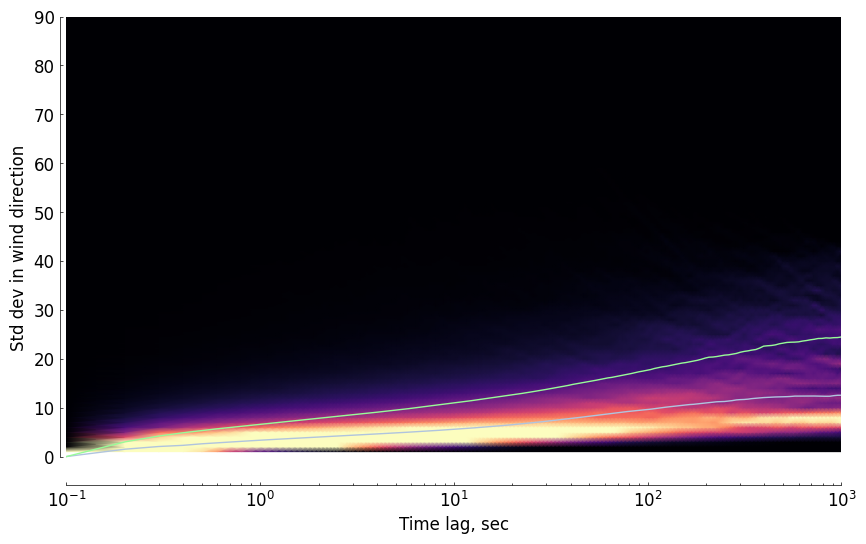

In [17]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

# reformat data
F = freq_df_d.T.values
F = F / df_d.shape[0]
lags = freq_df_d.index.astype('float')/10.
error_angles = np.array([c.right for c in freq_df_d.columns]).astype(int)

# Plot the heatmap
ax.pcolormesh(lags, error_angles, F, vmin=0, vmax=0.1, cmap='magma', shading='gouraud', rasterized=True)

# Plot lines
fifty=np.percentile(df_d, 50, axis=0)
eighty=np.percentile(df_d, 80, axis=0)
ax.plot(lags, fifty, linewidth=1, alpha=1,  color='lightsteelblue')
ax.plot(lags, eighty, linewidth=1, alpha=1,  color='palegreen')

# Set log scale and spines
ax.set_xscale('log')
yticks = np.arange(0, 90+10, 10)
xticks = [0.1, 1, 10, 100, 1000]
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],
                                 yticks=yticks,
                                 xticks=xticks,
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
ax.set_xlim(0.1, 1000)

# fix the minor ticks and spine
ax.tick_params(which='minor', length=2.5*0.5, color='black', direction='in', width=0.5)
ax.spines.bottom.set_bounds((0.1, 1000))

# set yticklabels
#evenyticks = np.arange(10, 90+10, 10)
#yticklabels = [['$' + str(y) + '^{\circ}$', ''] for y in evenyticks]
#yticklabels = np.ravel(yticklabels)[0:-1]
#ax.set_yticklabels(yticklabels)


# set labels
ax.set_ylabel('Std dev in wind direction')
ax.set_xlabel('Time lag, sec')
# set fontsize
fifi.mpl_functions.set_fontsize(ax, 12)



In [18]:
df_s=pd.read_hdf('WindHDFFiles/fixed_temporal_stds_angular/s2_10.20.20_totalangulartemporal.hdf')
df_s

/home/beast/.local/lib/python3.10/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


,index,1,2,3,4,5,6,7,8,9,...,6593,6905,7232,7575,7934,8309,8703,9115,9547,10000
0,0,0.0,0.090,0.082597,0.092837,0.104231,0.207237,0.217321,0.204252,0.239387,...,0.556511,0.561921,0.568472,0.591757,0.589746,0.594606,0.599711,0.595085,0.588941,0.579215
1,1,0.0,0.005,0.092014,0.097564,0.226486,0.234692,0.218352,0.253275,0.249152,...,0.556511,0.562010,0.568489,0.591771,0.589750,0.594613,0.599710,0.595117,0.588941,0.579236
2,2,0.0,0.095,0.109848,0.240455,0.239332,0.221635,0.265914,0.261531,0.250131,...,0.556509,0.562075,0.568573,0.591793,0.589761,0.594617,0.599701,0.595142,0.588936,0.579254
3,3,0.0,0.130,0.254209,0.237645,0.221414,0.281050,0.276428,0.263201,0.249755,...,0.556513,0.562147,0.568683,0.591866,0.589779,0.594665,0.599697,0.595164,0.588930,0.579269
4,4,0.0,0.310,0.268494,0.245701,0.307441,0.296910,0.279014,0.263201,0.270176,...,0.556532,0.562231,0.568842,0.591898,0.589856,0.594702,0.599708,0.595174,0.588930,0.579293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897243,112151,0.0,0.085,0.104243,0.353792,0.321534,0.295184,0.315407,0.360373,0.397663,...,0.702587,0.699014,0.695512,0.692277,0.703820,0.701183,0.701487,0.698509,0.702782,0.697093
897244,112152,0.0,0.040,0.340979,0.295582,0.264394,0.278712,0.322256,0.357806,0.420725,...,0.702651,0.698989,0.695516,0.692407,0.703798,0.701272,0.701748,0.698507,0.702895,0.697092
897245,112153,0.0,0.340,0.282410,0.248634,0.253172,0.292712,0.324804,0.387774,0.367302,...,0.702659,0.698979,0.695506,0.692648,0.703788,0.701356,0.701931,0.698505,0.702968,0.697087
897246,112154,0.0,0.225,0.219545,0.210758,0.246609,0.275903,0.341252,0.325708,0.316115,...,0.702711,0.698972,0.695503,0.692886,0.703802,0.701448,0.702024,0.698504,0.703036,0.697090


In [19]:
df_s=df_s.drop(columns='index')

In [20]:
#get timelags from column headers
timelags=np.array(list(df_s.columns))
bins=np.arange(0,2.01,.01)
newcol=np.empty((len(timelags), 0)).tolist()

In [21]:
#make a new list that counts directional frequencies for each column
j=0
for i in timelags:
    newcol[j]=df_s[i].value_counts(ascending=True, bins=bins).sort_index()
    j=j+1

In [22]:
freq_df_s=pd.DataFrame(newcol)
freq_df_s

,"(-0.001, 0.01]","(0.01, 0.02]","(0.02, 0.03]","(0.03, 0.04]","(0.04, 0.05]","(0.05, 0.06]","(0.06, 0.07]","(0.07, 0.08]","(0.08, 0.09]","(0.09, 0.1]",...,"(1.9, 1.91]","(1.91, 1.92]","(1.92, 1.93]","(1.93, 1.94]","(1.94, 1.95]","(1.95, 1.96]","(1.96, 1.97]","(1.97, 1.98]","(1.98, 1.99]","(1.99, 2.0]"
1,897248,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,91419,94250,98918,77561,78503,59276,59041,42825,44635,32467,...,0,0,0,0,0,0,0,0,0,0
3,17078,37625,64091,62779,77363,63422,66796,57705,56176,47496,...,0,0,0,0,0,0,0,1,0,0
4,2668,17444,35226,49201,58541,61531,64089,60823,57404,53753,...,0,0,0,0,0,0,0,0,1,1
5,607,7554,20993,35639,46623,54228,58120,59138,57689,55193,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


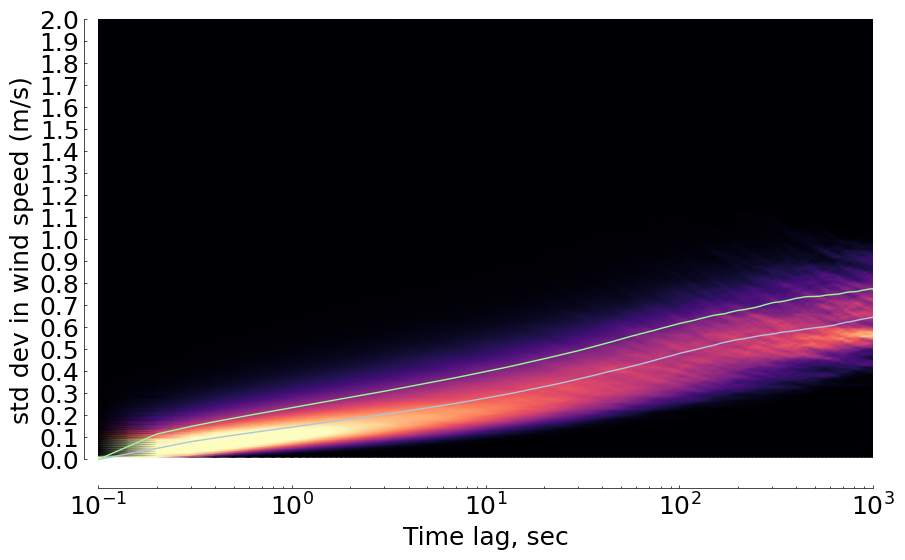

In [23]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

# reformat data
F = freq_df_s.T.values
F = F / df_s.shape[0]
lags = freq_df_s.index.astype('float')/10.
error_angles = np.array([c.right for c in freq_df_s.columns]).astype(float)

# Plot the heatmap
ax.pcolormesh(lags, error_angles, F, vmin=0, vmax=0.05, cmap='magma', shading='gouraud', rasterized=True)

# Plot lines
fifty=np.percentile(df_s, 50, axis=0)
eighty=np.percentile(df_s, 80, axis=0)
ax.plot(lags, fifty, linewidth=1, alpha=1,  color='lightsteelblue')
ax.plot(lags, eighty, linewidth=1, alpha=1,  color='palegreen')

# Set log scale and spines
ax.set_xscale('log')
yticks = np.arange(0, 2.1, .1)
xticks = [0.1, 1, 10, 100, 1000]
fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],
                                 yticks=yticks,
                                 xticks=xticks,
                                 tick_length=2.5,
                                 spine_locations={'left': 10, 'bottom': 5},
                                 linewidth=0.5)
ax.set_xlim(0.1, 1000)

# fix the minor ticks and spine
ax.tick_params(which='minor', length=2.5*0.5, color='black', direction='in', width=0.5)
ax.spines.bottom.set_bounds((0.1, 1000))


# set labels
ax.set_ylabel('std dev in wind speed (m/s)')
ax.set_xlabel('Time lag, sec')
# set fontsize
fifi.mpl_functions.set_fontsize(ax, 18)



### 3 examples of wind direction variability

In [35]:
df1=pd.read_hdf('Github repo/raw_data_for_me/small_10.20.20_maskedgpsdata.hdf')
df2=pd.read_hdf('Github repo/raw_data_for_me/small_7.7.21_maskedgpsdata.hdf')
df3=pd.read_hdf('Github repo/raw_data_for_me/small_9.26.21_maskedgpsdata.hdf')
df4=pd.read_hdf('Github repo/raw_data_for_me/small_10.29.21_maskedgpsdata.hdf')
df5=pd.read_hdf('Github repo/raw_data_for_me/small_10.30.21_maskedgpsdata.hdf')
df6=pd.read_hdf('Github repo/raw_data_for_me/small_1.8.22_maskedgpsdata.hdf')
df7=pd.read_hdf('Github repo/raw_data_for_me/small_1.11.22_maskedgpsdata.hdf')
df8=pd.read_hdf('Github repo/raw_data_for_me/small_1.15.22_maskedgpsdata.hdf')
df9=pd.read_hdf('Github repo/raw_data_for_me/small_4.30.22_maskedgpsdata.hdf')
df10=pd.read_hdf('Github repo/raw_data_for_me/small_5.1.22_maskedgpsdata.hdf')
df11=pd.read_hdf('Github repo/raw_data_for_me/small_5.2.22_maskedgpsdata.hdf')
df12=pd.read_hdf('Github repo/raw_data_for_me/small_6.1.22_maskedgpsdata.hdf')
df13=pd.read_hdf('Github repo/raw_data_for_me/small_6.3.22_maskedgpsdata.hdf')
df14=pd.read_hdf('Github repo/raw_data_for_me/small_6.7.22_maskedgpsdata.hdf')
df15=pd.read_hdf('Github repo/raw_data_for_me/small_6.8.22_maskedgpsdata.hdf')
df16=pd.read_hdf('Github repo/raw_data_for_me/small_6.22.22_maskedgpsdata.hdf')

In [ ]:
df_d6=pd.read_hdf('WindHDFFiles/fixed_temporal_stds_angular/d_1.8.22_totalangulartemporal.hdf')
df_d8=pd.read_hdf('WindHDFFiles/fixed_temporal_stds_angular/d_1.15.22_totalangulartemporal.hdf')
df_d14=pd.read_hdf('WindHDFFiles/fixed_temporal_stds_angular/d_6.7.22_totalangulartemporal.hdf')

In [37]:
time_series_length=max(df_d6['index'])
df_d6=df_d6.iloc[(80000+(time_series_length*2)):(100000+(time_series_length*2))].drop(columns='index').fillna(0) #choose calculations from the 3rd sensor
df_d6=df_d6*180/np.pi
timelags=np.array(list(df_d6.columns))
bins=np.arange(0,91)
newcol=np.empty((len(timelags), 0)).tolist()
j=0
for i in timelags:
    newcol[j]=df_d6[i].value_counts(ascending=True, bins=bins).sort_index()
    j=j+1

freq_df6=pd.DataFrame(newcol)  

In [38]:
df_d8=df_d8.iloc[8000:28000].drop(columns='index').fillna(0) #choose calculations from the 1st sensor
df_d8=df_d8*180/np.pi
timelags=np.array(list(df_d8.columns))
bins=np.arange(0,91)
newcol=np.empty((len(timelags), 0)).tolist()
j=0
for i in timelags:
    newcol[j]=df_d8[i].value_counts(ascending=True, bins=bins).sort_index()
    j=j+1

freq_df8=pd.DataFrame(newcol)    

In [39]:
#choosing index which corresponds to the sensor and timeframe of desired signal time series
time_series_length=df_d14['index'].iloc[-1]
df_d14=df_d14.iloc[(20000+(time_series_length)):(40000+(time_series_length))].drop(columns='index').fillna(0) #choose calculations from the 3rd sensor
df_d14=df_d14*180/np.pi
timelags=np.array(list(df_d14.columns))
bins=np.arange(0,91)
newcol=np.empty((len(timelags), 0)).tolist()
j=0
for i in timelags:
    newcol[j]=df_d14[i].value_counts(ascending=True, bins=bins).sort_index()
    j=j+1

freq_df14=pd.DataFrame(newcol)    

In [53]:
plt.rcParams.update({'font.size': 26})

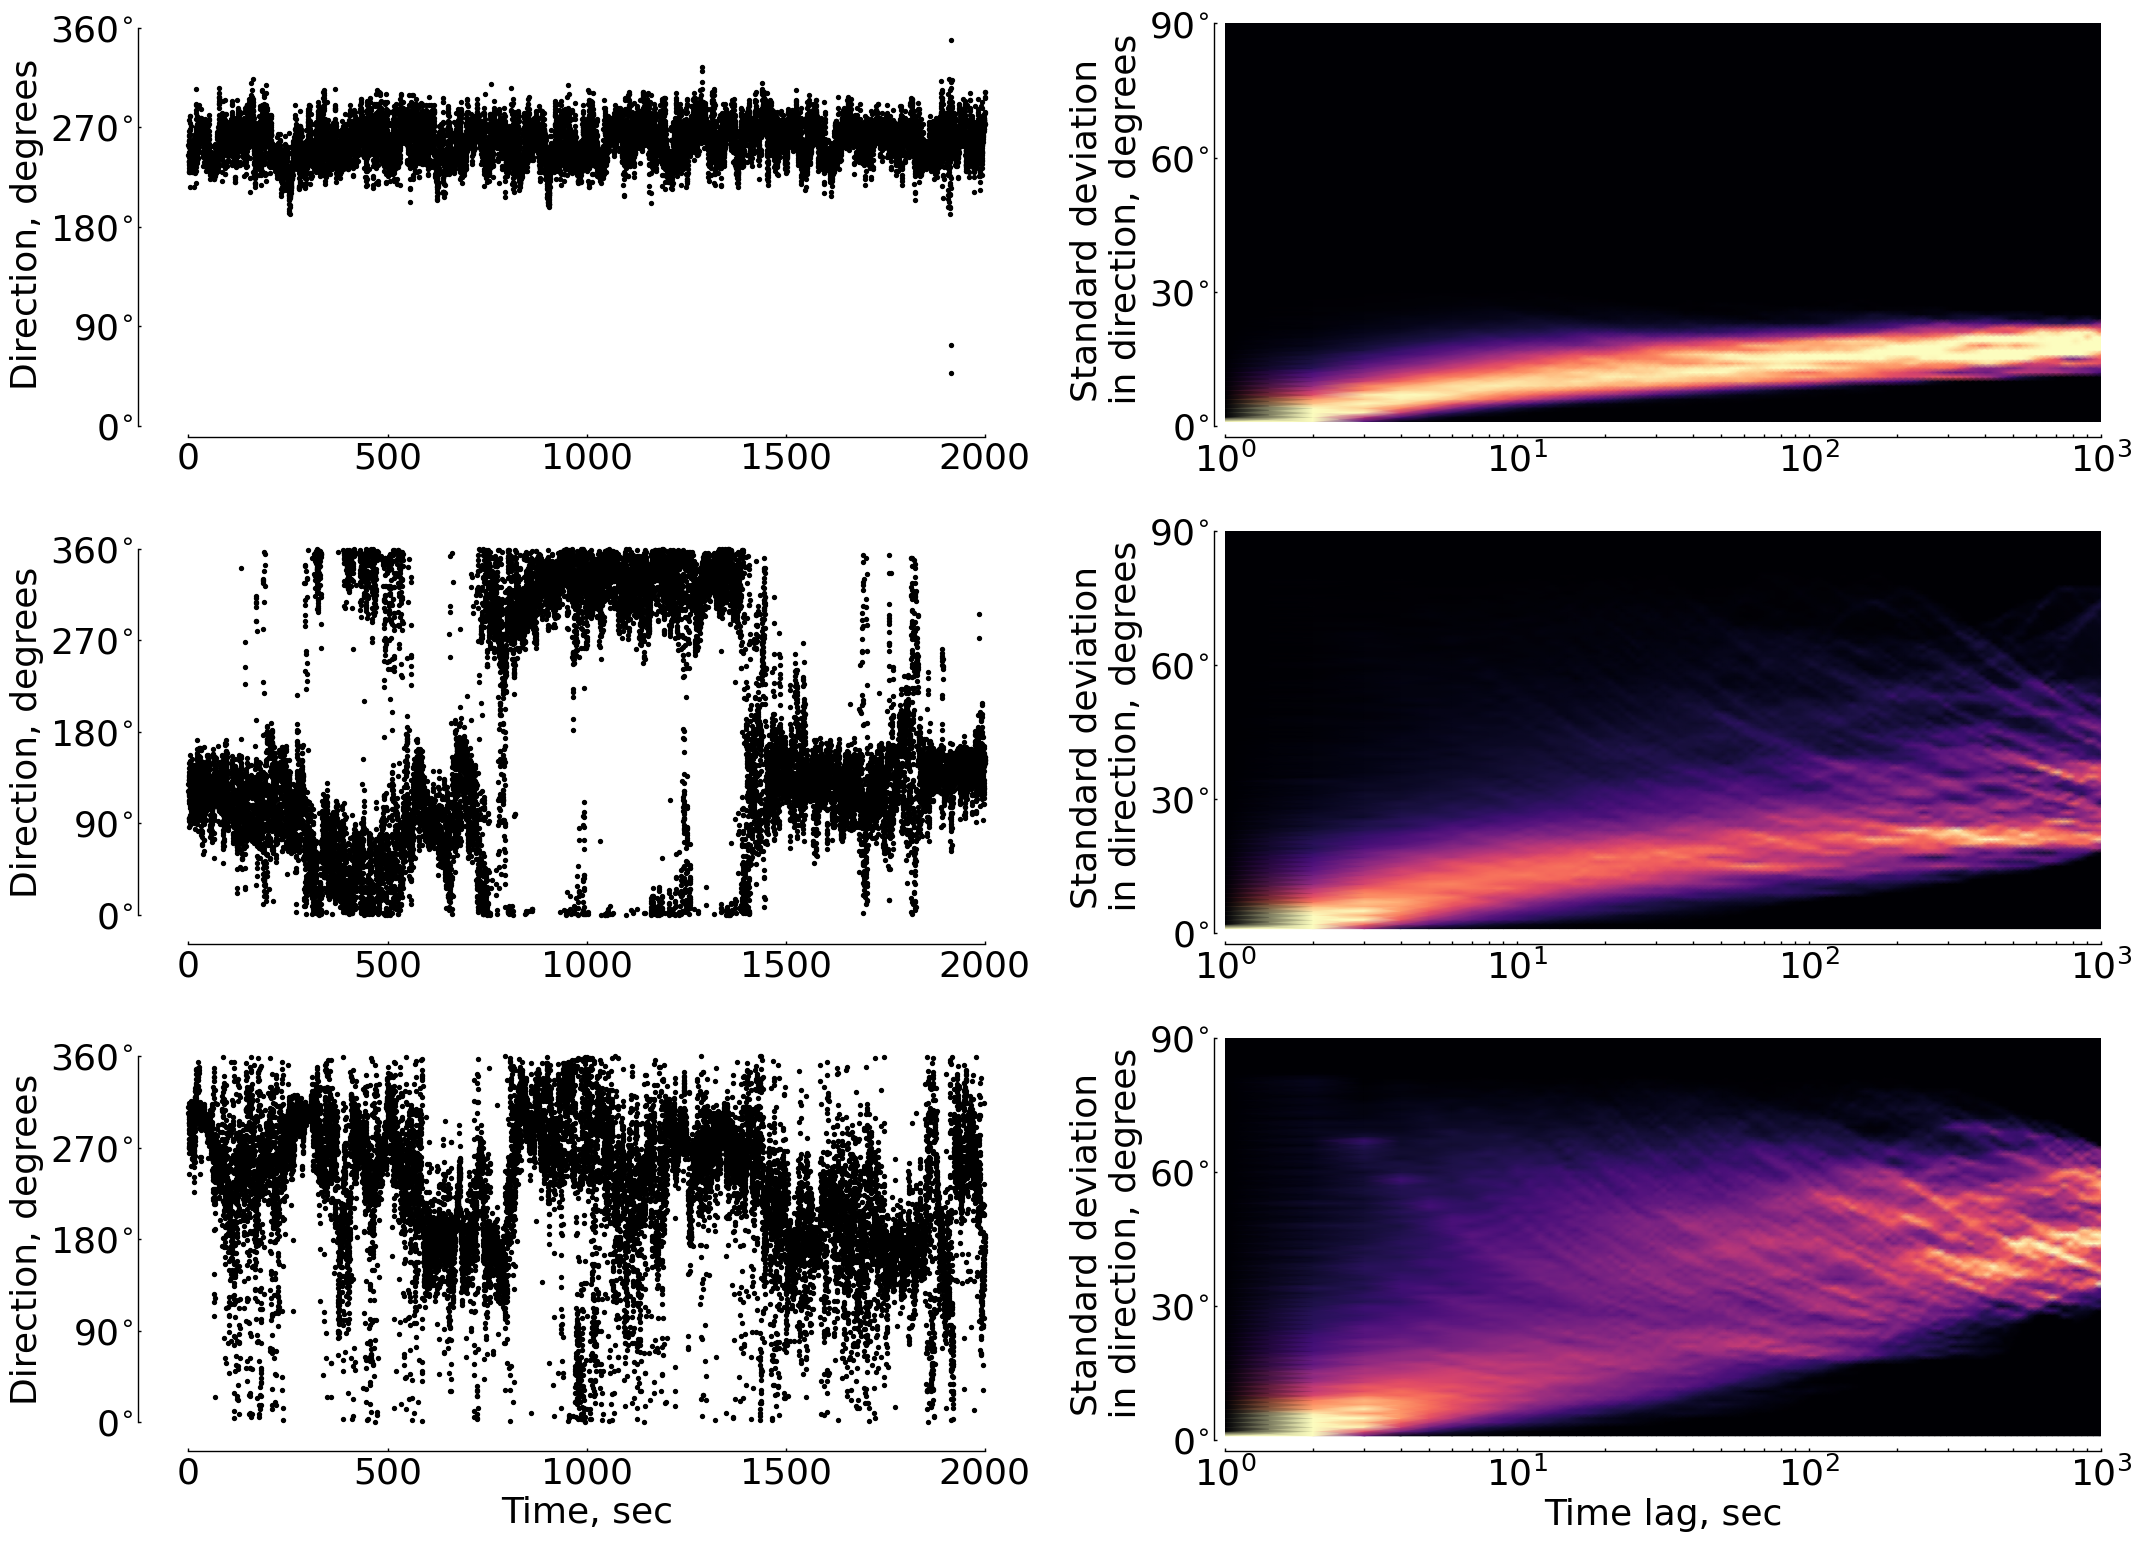

In [59]:
fig, ax =plt.subplots(nrows=3, ncols=2, figsize=(22,16), layout='tight', rasterized=True)


#ax[0,1].imshow(im_d1, extent=[0,1000,0,180], aspect='auto')
time=np.linspace(0,2000,20000)
ax[0,0].scatter(time, df14.D_2.iloc[20000:40000], s=8, color='k', label='forest 6.7.22')
ax[1,0].scatter(time, df8.D_1.iloc[8000:28000], s=8, color='k',label='lemmon valley, 1.15.22')
ax[2,0].scatter(time, df6.D_3.loc[80001:100000], s=8, color='k',label='backyard, 1.8.22')



# reformat data
F_14 = freq_df14.T.values
F_14 = F_14 / df_d14.shape[0]
lags = freq_df14.index.astype('float')/10.
error_angles14 = np.array([c.right for c in freq_df14.columns]).astype(int)
ax[0,1].pcolormesh(freq_df14.index.astype('float'), error_angles14, F_14, cmap='magma', vmin=0, vmax=.1 , shading='gouraud', rasterized=True) 
ax[0,1].set_xscale('log')


# reformat data
F_8 = freq_df8.T.values
F_8 = F_8 / df_d8.shape[0]
lags = freq_df8.index.astype('float')/10.
error_angles8 = np.array([c.right for c in freq_df8.columns]).astype(int)
ax[1,1].pcolormesh(freq_df8.index.astype('float'), error_angles8, F_8, cmap='magma', vmin=0, vmax=.07 , shading='gouraud', rasterized=True) 
ax[1,1].set_xscale('log')

# reformat data
F_6 = freq_df6.T.values
F_6 = F_6 / df_d6.shape[0]
lags = freq_df6.index.astype('float')/10.
error_angles6 = np.array([c.right for c in freq_df6.columns]).astype(int)
ax[2,1].pcolormesh(freq_df6.index.astype('float'), error_angles6, F_6, cmap='magma', vmin=0, vmax=.05 , shading='gouraud', rasterized=True) 
ax[2,1].set_xscale('log')



ax[0,1].set_xlim(1, 1000)
ax[1,1].set_xlim(1, 1000)
ax[2,1].set_xlim(1, 1000)

#ax[1,1].xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
#ax[1,1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
# fix the minor ticks and spine
ax[0,1].tick_params(which='minor', length=2.5*0.5, color='black', direction='in', width=0.5)


ax[0,1].spines.bottom.set_bounds((0.1, 1000))
fifi.mpl_functions.adjust_spines(ax[0,1], ['left', 'bottom'],
                                 yticks=np.arange(0, 90+10, 30),
                                 xticks=[1,10, 100,  1000],
                                 tick_length=2.5,
                                 spine_locations={'left': 8, 'bottom': 8},
                                 linewidth=1)
# fix the minor ticks and spine
ax[1,1].tick_params(which='minor', length=2.5*0.5, color='black', direction='in', width=0.5)
ax[1,1].spines.bottom.set_bounds((0.1, 1000))

fifi.mpl_functions.adjust_spines(ax[1,1], ['left', 'bottom'],
                                 yticks=np.arange(0, 90+10, 30),
                                 xticks=[1,10, 100,  1000],
                                 tick_length=2.5,
                                 spine_locations={'left': 8, 'bottom': 8},
                                 linewidth=1)


# fix the minor ticks and spine
ax[2,1].tick_params(which='minor', length=2.5*0.5, color='black', direction='in', width=0.5)
ax[2,1].spines.bottom.set_bounds((0.1, 1000))

fifi.mpl_functions.adjust_spines(ax[2,1], ['left', 'bottom'],
                                 yticks=np.arange(0, 90+10, 30),
                                 xticks=[1,10, 100,  1000],
                                 tick_length=2.5,
                                 spine_locations={'left': 8, 'bottom': 8},
                                 linewidth=1)




fifi.mpl_functions.adjust_spines(ax[0,0], ['left', 'bottom'],
                                
                                 xticks=[0,500,1000,1500,2000],
                                 yticks=np.arange(0, 360+10, 90),
                                 tick_length=2.5,
                                 spine_locations={'left': 8, 'bottom': 8},
                                 linewidth=1)


fifi.mpl_functions.adjust_spines(ax[1,0], ['left', 'bottom'],
                                
                                 xticks=[0,500,1000,1500,2000],
                                 yticks=np.arange(0, 360+10, 90),
                                 tick_length=2.5,
                                 spine_locations={'left': 8, 'bottom': 8},
                                 linewidth=1)


fifi.mpl_functions.adjust_spines(ax[2,0], ['left', 'bottom'],
                                
                                 xticks=[0,500,1000,1500,2000],
                                 yticks=np.arange(0, 360+10, 90),
                                 tick_length=2.5,
                                 spine_locations={'left': 8, 'bottom': 8},
                                 linewidth=1)



evenyticks=np.arange(0, 360+10, 90)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax[0,0].set_yticklabels(yticklabels)
ax[1,0].set_yticklabels(yticklabels)
ax[2,0].set_yticklabels(yticklabels)

evenyticks=np.arange(0, 100, 30)
yticklabels=[['$' + str(y) + '^{\circ}$' + '',] for y in evenyticks]
yticklabels=np.ravel(yticklabels)
ax[0,1].set_yticklabels(yticklabels)
ax[1,1].set_yticklabels(yticklabels)
ax[2,1].set_yticklabels(yticklabels)




ax[0,1].tick_params(which='minor', length=2.5*1, color='black', direction='in', width=1)
#ax[0,1].spines.bottom.set_bounds((.1, 1000))
ax[1,1].tick_params(which='minor', length=2.5*1, color='black', direction='in', width=1)
#ax[1,1].spines.bottom.set_bounds((.1, 1000))
ax[2,1].tick_params(which='minor', length=2.5*1, color='black', direction='in', width=1)
#ax[2,1].spines.bottom.set_bounds((.1, 1000))

ax[0,0].set_ylabel('Direction, degrees')
ax[1,0].set_ylabel('Direction, degrees')
ax[2,0].set_ylabel('Direction, degrees')

ax[0,1].set_ylabel('Standard deviation \n in direction, degrees')
ax[1,1].set_ylabel('Standard deviation \n in direction, degrees')
ax[2,1].set_ylabel('Standard deviation \n in direction, degrees')



ax[2,0].set_xlabel('Time, sec')
ax[2,1].set_xlabel('Time lag, sec')


#ax[0,0].set_title('Wind direction')
#ax[0,1].set_title('Standard deviation in wind direction')

fig.savefig('examplesofwindvariability.svg', format='svg')

